In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
# tf.compat.v1.random.set_random_seed(1234)

In [4]:
df = pd.read_excel('../dataset/hchi_ratio_simplified.xlsx')
df.head()

,dates,HC,HI,HCHI
0,2018-11-07 17:15:00,10671,26164,0.407850
1,2018-11-07 17:16:00,10725,26263,0.408369
2,2018-11-07 17:17:00,10726,26262,0.408423
3,2018-11-07 17:18:00,10727,26269,0.408352
4,2018-11-07 17:19:00,10733,26274,0.408503


In [30]:
TEST_SIZE = 60 # minutes
DATASET_SIZE = df.shape[0] # rows

In [45]:
minmax = MinMaxScaler().fit(df.loc[:DATASET_SIZE - TEST_SIZE - 1, 'HCHI'].astype('float32').values.reshape(-1, 1)) # select HCHI ratio column
df_log = minmax.transform(df.loc[:DATASET_SIZE - TEST_SIZE - 1, 'HCHI'].astype('float32').values.reshape(-1, 1)) # select HCHI ratio column
df_log = pd.DataFrame(df_log)
df_log.head()
df_log.shape
# df.shape

(141, 1)

## Forecast

This example is using model 1.lstm, if you want to use another model, need to tweak a little bit, but I believe it is not that hard.

I want to forecast 30 days ahead! So just change `test_size` to forecast `t + N` ahead.

Also, I want to simulate 10 times, 10 variances of forecasted patterns. Just change `simulation_size`.

In [52]:
simulation_size = 2
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = TEST_SIZE
learning_rate = 0.01

df_train = df_log
df.shape, df_train.shape

((201, 4), (141, 1))

In [53]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [54]:
from tensorflow.python.framework import ops

def forecast():
    ops.reset_default_graph()
#     tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [55]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|███████████████| 300/300 [00:38<00:00,  7.74it/s, acc=95.8, cost=0.00413]


simulation 2


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|███████████████| 300/300 [00:47<00:00,  6.32it/s, acc=95.3, cost=0.00555]


In [71]:
date_ori = df.iloc[:, 0]
# date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
# # for i in range(test_size):
# #     date_ori.append(date_ori[-1] + timedelta(days = 1))
# date_ori = pd.Series(date_ori).dt.strftime(date_format = '%m-%d-%Y').tolist()
date_ori[-5:]

196   2018-11-07 20:32:00
197   2018-11-07 20:33:00
198   2018-11-07 20:34:00
199   2018-11-07 20:35:00
200   2018-11-07 20:36:00
Name: dates, dtype: datetime64[ns]

## Sanity check

Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,
1. If one of element in forecasted trend lower than min(original trend).
2. If one of element in forecasted trend bigger than max(original trend) * 2.

If both are true, reject that trend.

In [72]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['HCHI'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['HCHI']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

2

In [77]:
results_frame = pd.DataFrame(accepted_results)
results_frame = results_frame.transpose() 

results_frame['Dates'] = date_ori
cols = results_frame.columns.tolist()
cols = cols[-1:] + cols[:-1] # move 'Dates' column in front
results_frame = results_frame[cols] 

results_frame.to_excel('./HCHI_predictions.xlsx')
results_frame.head

<bound method NDFrame.head of                   Dates         0         1
0   2018-11-07 17:15:00  0.407850  0.407850
1   2018-11-07 17:16:00  0.408163  0.408134
2   2018-11-07 17:17:00  0.408320  0.408313
3   2018-11-07 17:18:00  0.408370  0.408332
4   2018-11-07 17:19:00  0.408490  0.408468
5   2018-11-07 17:20:00  0.408415  0.408391
6   2018-11-07 17:21:00  0.408385  0.408365
7   2018-11-07 17:22:00  0.408313  0.408318
8   2018-11-07 17:23:00  0.408264  0.408274
9   2018-11-07 17:24:00  0.408309  0.408243
10  2018-11-07 17:25:00  0.408294  0.408258
11  2018-11-07 17:26:00  0.408310  0.408271
12  2018-11-07 17:27:00  0.408323  0.408322
13  2018-11-07 17:28:00  0.408342  0.408332
14  2018-11-07 17:29:00  0.408305  0.408308
15  2018-11-07 17:30:00  0.408315  0.408283
16  2018-11-07 17:31:00  0.408371  0.408311
17  2018-11-07 17:32:00  0.408349  0.408316
18  2018-11-07 17:33:00  0.408431  0.408331
19  2018-11-07 17:34:00  0.408406  0.408374
20  2018-11-07 17:35:00  0.408512  0.408413
21

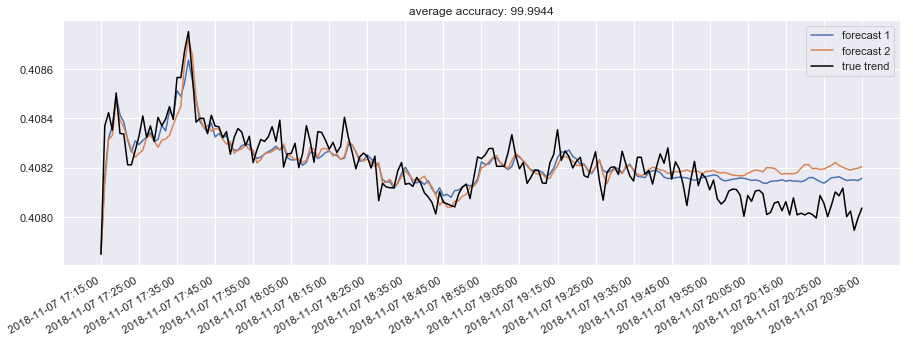

In [97]:
accuracies = [calculate_accuracy(df['HCHI'].values, r[:]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['HCHI'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
tick_size = int(DATASET_SIZE / 20)
plt.xticks(x_range_future[::tick_size], date_ori[::tick_size])
plt.gcf().autofmt_xdate()
plt.savefig('plot.png')
plt.show()

In [14]:
accepted_results_arr = np.array(accepted_results)
print(accepted_results_arr[:, -3:])

[[0.40800844 0.40800817 0.40798996]]


In [103]:
# apple_true = np.array((256.769989, 258.73999, 258.690002))
apple_true = np.array((257.5, 257.130005, 257.23999, 259.429993, 260.140015))

In [104]:
last_5_days = accepted_results_arr[:, -5:]
print('last_5_days:')
print(last_5_days)
one_day_errors = []
stock_prices = []
for index, value in enumerate(apple_true):
    average = np.average(last_5_days[:, index])
    stock_prices.append(average)
    one_day_error = np.absolute((value - average) / value)
    one_day_errors.append(one_day_error)

last_5_days:
[[256.14439692 250.63901862 251.693824   251.88362819 252.83163022]
 [256.13927172 260.35440632 260.12555274 262.81072272 262.0365631 ]
 [250.87822534 254.34370098 261.62186624 269.30134269 264.47879113]
 [252.1567968  258.03550671 258.81993737 253.5459127  253.24749009]
 [254.33523623 258.0194085  260.30598047 262.75770029 267.05491078]
 [253.12546475 258.73195836 259.9033387  263.23624131 262.09332997]
 [254.26062706 257.53375804 257.5342592  257.65185775 257.81110624]
 [261.15909092 264.82061553 263.40692201 262.74157434 269.29185288]
 [258.21520207 262.38988126 264.10371594 267.88287266 278.96766162]
 [256.55363493 257.39604041 263.82520835 272.13500991 272.90908831]]


In [105]:
one_day_errors

[0.008556137191795616,
 0.004264086066432743,
 0.011250468883082471,
 0.011427719750980043,
 0.015115811513262883]

In [106]:
stock_prices

[255.29679467311263,
 258.22642947158226,
 260.1340605029794,
 262.39468625500274,
 264.0722424337974]

In [107]:
one_day_errors_raw = []
for index, value in enumerate(apple_true):
    average = np.average(last_5_days[:, index])
    one_day_error_raw = (value - average) / value
    one_day_errors_raw.append(one_day_error_raw)

In [108]:
one_day_errors_raw

[0.008556137191795616,
 -0.004264086066432743,
 -0.011250468883082471,
 -0.011427719750980043,
 -0.015115811513262883]

In [110]:
three_day_avg_errors = []
three_day_avg_errors_raw = []
three_day_exp_errors = []
three_day_exp_errors_raw = []

for i in range(len(one_day_errors) - 2):
    three_day_avg_error = np.average(one_day_errors[i: i+3])
    three_day_avg_errors.append(three_day_avg_error)
    
    three_day_avg_error_raw = np.average(one_day_errors_raw[i: i+3])
    three_day_avg_errors_raw.append(three_day_avg_error_raw)
    
    three_day_exp_error = (one_day_errors[i] + one_day_errors[i+1] * 2 + one_day_errors[i+2] * 3) / 6
    three_day_exp_errors.append(three_day_exp_error)
    
    three_day_exp_error_raw = (one_day_errors_raw[i] + one_day_errors_raw[i+1] * 2 + one_day_errors_raw[i+2] * 3) / 6
    three_day_exp_errors_raw.append(three_day_exp_error_raw)

print('three_day_avg_errors:')
print(three_day_avg_errors)

print('three_day_avg_errors_raw:')
print(three_day_avg_errors_raw)

print('three_day_exp_errors:')
print(three_day_exp_errors)

print('three_day_exp_errors_raw:')
print(three_day_exp_errors_raw)

three_day_avg_errors:
[0.00802356404710361, 0.008980758233498419, 0.012598000049108465]
three_day_avg_errors_raw:
[-0.002319472585906533, -0.008980758233498419, -0.012598000049108465]
three_day_exp_errors:
[0.008472619328984753, 0.01017469718092297, 0.0132422238208052]
three_day_exp_errors_raw:
[-0.005620573598386215, -0.01017469718092297, -0.0132422238208052]


In [111]:
# As shown in csv file name
COMPANY_NAME = 'tesla'

# 'High', 'Low', or 'Close'
COLUMN_USED = 'Low'

results_frame.to_csv('./{}_{}_predictions.csv'.format(COMPANY_NAME, COLUMN_USED))
